In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
from riotwatcher import RiotWatcher
import requests

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

# Get matchids for challenger tier players
because there is no api call to just get a bunch matches I have to do some weird stuff. My strategy is: get challenger player list from the region -> getsummoner by playerid to get accountid -> get recent matches from each player -> check duplicates -> get match details

also can swap challenger to masters p easy. swapping to lower leagues is a bit harder


In [91]:
#regions = ['RU','KR', 'BR1', 'OC1', 'JP1', 'NA1', 'EUN1', 'EUW1', 'TR1', 'LA1', 'LA2']
regions = ['TR1', 'LA1']
regions=regions[::-1]
print(regions)
#gameid_list = {}
league_items = {}

#choose tier, division, and queue
#for tier lower than master need to get league codes then get league items
#valid tiers CHALLENGER, MASTERS, DIAMOND, PLATINUM, GOLD, SILVER, BRONZE, IRON
#valid divisions I, II, III, IV
tier = 'CHALLENGER'
division = 'I'
queue = 'RANKED_SOLO_5x5'

['LA1', 'TR1']


In [92]:
#get last challenger games for each player in each region (purge duplicates)
#first loop through regions
for region in regions:
    league_items[region] = []
    
    #get all 'items' in the challenger league for solo queue (not sure about 'flex' queues?)
    #changed to master tier because that is the highest until mid january
    if tier=='CHALLENGER':
        league_items[region] = watcher.league.challenger_by_queue(region, queue)['entries']
    elif tier=='MASTERS':
        league_items[region] = watcher.league.masters_by_queue(region,queue)['entries']
    else:
        #this entries method doesn't exist yet (as of 20190428)
        league_codes = watcher.league.entries(region, 'RANKED_SOLO_5x5',tier)
        for league in league_codes:
                leagues_items[region].append(watcher.league.by_id(region,league)['entries'])

    #initialize gameid_list items
    gameid_list[region] = []

#loop through all items in each region's league to get matchid's
for region in regions:
    print(region)

    #get 100 matches from each player  
    for entry in league_items[region]:

        #convert player_id(aka summoner_id) to account_id
        account_id = watcher.summoner.by_id(region, entry['summonerId'])['accountId']

        #don't keep all matches in memory or on disk - we will get full match details later
        #queue = 420 is the code for 5x5_solo_queue
        match_list = watcher.match.matchlist_by_account(region,
                                     account_id,
                                     queue=420,
                                     begin_index = 1,
                                     end_index=100)['matches']
        match_list = watcher.match.matchlist_by_account(region,
                                    account_id,
                                    queue=420,
                                    begin_index=101,
                                    end_index=200)['matches'] 
        match_list = watcher.match.matchlist_by_account(region,
                                    account_id,
                                    queue=420,
                                    begin_index=201,
                                    end_index=300)['matches']
        #keep gameid_list in memory for later use and for easy purging of duplicates
        for match in match_list:
            gameid_list[region].append(match['gameId']) 

   #purge duplicates from gameid_list
        gameid_list[region] = list(set(gameid_list[region]))

       

LA1
TR1


In [93]:
with open(os.path.join('LOL_data',str(tier)+'_tier','saved'+time.strftime('%Y-%m-%d')+'.json'), 'w') as fp:
    json.dump(gameid_list, fp)

# Get match details

## Load data into dataframe
Do this from a file. Also reindex DF so that we can hopefully call each region in a mixed rather than sequential way

In [94]:
#get all files in challenger_tier data folder, then sort by date
files = glob.glob(os.path.join('LOL_data',tier+'_tier','*.json'))
files.sort(key=os.path.getmtime)
print(files)

['LOL_data/CHALLENGER_tier/saved2019-04-08.json', 'LOL_data/CHALLENGER_tier/saved2019-05-04.json', 'LOL_data/CHALLENGER_tier/saved2019-05-28.json']


In [95]:
lol_df = pd.DataFrame()
region_list = []
gameid_load_list = []

with open(files[-1],'r') as fp:
    for key, item in json.load(fp).items():
        region_list.extend([key] * len(item))
        gameid_load_list.extend(item)
        
lol_df['region'] = region_list
lol_df['gameid'] = gameid_load_list
lol_df.describe()

,gameid
count,1.727890e+05
mean,2.089882e+09
std,1.339837e+09
min,1.411546e+08
25%,6.860392e+08
50%,2.106607e+09
75%,3.578494e+09
max,4.033445e+09


In [96]:
lol_df_prev = pd.DataFrame()
region_list_prev = []
gameid_load_list_prev = []

#load second most recent data file to check duplicates
with open(files[-2],'r') as fp:
    for key, item in json.load(fp).items():
        region_list_prev.extend([key] * len(item))
        gameid_load_list_prev.extend(item)

#drop duplicates
#this is definitely an inefficient way to do it, but idk how to do it better
for region,gameid in zip(region_list_prev,gameid_load_list_prev):
    duplicate = lol_df.loc[lol_df['region']==region]
    duplicate = duplicate.loc[duplicate['gameid']==gameid]
    if len(duplicate!=0):
        lol_df.drop(duplicate.index,inplace=True)
lol_df.describe

<bound method NDFrame.describe of        region      gameid
1         LA2   691044356
2         LA2   675643396
3         LA2   677675014
6         LA2   679215108
8         LA2   684818448
9         LA2   660340756
10        LA2   685801493
11        LA2   677937178
13        LA2   648085534
14        LA2   531955742
16        LA2   645431331
17        LA2   636157987
18        LA2   672104486
20        LA2   689307683
21        LA2   688390185
23        LA2   686129195
24        LA2   687046702
27        LA2   669286449
28        LA2   684490800
29        LA2   651755571
30        LA2   659030067
31        LA2   634126389
32        LA2   480247854
33        LA2   657391675
36        LA2   659161153
37        LA2   681181250
39        LA2   637501507
40        LA2   622493765
41        LA2   658636870
42        LA2   685342791
...       ...         ...
172745     RU   187662263
172747     RU   171777977
172748     RU   199770042
172750     RU   195542972
172751     RU   200376249
1727

In [97]:
#reindex randomly so that we don't loop through regions sequentially
#this way we more efficiently use the api calls we're allotted
lol_df = lol_df.reindex(np.random.permutation(lol_df.index))

## Get match details from riotwatcher api

In [98]:
blue_win = []
red_gold = []
blue_gold = []
blue_tower_kills=[]
red_tower_kills=[]
blue_inhibitor_kills=[]
red_inhibitor_kills=[]
blue_baron_kills=[]
red_baron_kills=[]
blue_dragon_kills=[]
red_dragon_kills=[]
blue_champs = []
red_champs = []
bad_element_list = []
region_list = []
gameid_list = []
for i,row in lol_df[:].iterrows():
    
    #NOTE: Summoner spell info is included in match_details but may be hard to keep linked to participants
    #NOTE 2: Timeline info. can give timeline info on many things for teams and individual participants
    #   this could be used for training  a real time win probability model.
    try:
        match_details = watcher.match.by_id(row['region'],row['gameid'])   
    except requests.exceptions.HTTPError as err:
        print(err)
        print('Error at row:',row['gameid'])
        print('element:',i)
        bad_element_list.append(i)
        continue
        
    #skip element and mark as bad element if not 10 team members
    if len(match_details['participants'])!=10:
        bad_element_list.append(i)
        continue
    #append region_list and gameid_list so we don't have to
    #deal with wrong bad region, gameid
    region_list.append(row['region'])
    gameid_list.append(row['gameid'])
    
    #blue win is true if teamid=100 (blue) and this same team won
    blue_win.append(int(match_details['teams'][0]['win']=='Win' and match_details['teams'][0]['teamId']==100))

    #add blue gold and red gold (at end of match) to lists
    #intention for this is to take the difference then normalize by the total (to control for long vs. short games)
    blue_gold_match = 0
    red_gold_match = 0

    for participant in match_details['participants']:
        if participant['teamId']==100:
            blue_gold_match+=participant['stats']['goldEarned']
        else:
            red_gold_match+=participant['stats']['goldEarned']
    blue_gold.append(blue_gold_match)
    red_gold.append(red_gold_match)
    
    #add blue and red tower kills (at end of match) to lists
    #should take difference and normalize by the total towers
    try:
        blue_tower_kills.append(match_details['teams'][0]['towerKills'])
    except KeyError as err:
        print(err)
        print('Error at row:',row['gameid'])
        print('element:',i)
        bad_element_list.append(i)
        del region_list[-1]
        del gameid_list[-1]
        del blue_win[-1]
        del blue_gold[-1]
        del red_gold[-1]
        continue
    red_tower_kills.append(match_details['teams'][1]['towerKills'])
    
    #add blue and red tower kills (at end of match) to lists
    #should take difference and normalize by the total towers
    blue_inhibitor_kills.append(match_details['teams'][0]['inhibitorKills'])
    red_inhibitor_kills.append(match_details['teams'][1]['inhibitorKills'])
    
    #add blue and red tower kills (at end of match) to lists
    #like gold, should take diff and normalize
    blue_baron_kills.append(match_details['teams'][0]['baronKills'])
    red_baron_kills.append(match_details['teams'][1]['baronKills'])
    
    #add blue and red dragon kills (at end of match) to lists
    #like gold, the intention of this is to take the difference and normalize
    blue_dragon_kills.append(match_details['teams'][0]['dragonKills'])
    red_dragon_kills.append(match_details['teams'][1]['dragonKills'])

    #build team champion lineups and append to columns
    blue_champ_row = []
    red_champ_row = []
    for participant in match_details['participants']:
        if participant['teamId'] == 100:
            blue_champ_row.append(participant['championId'])
        elif participant['teamId'] ==200:
            red_champ_row.append(participant['championId'])
        else:
            print('Illegal team value!',participant['teamId'])
            break
    blue_champs.append(blue_champ_row)
    red_champs.append(red_champ_row)    

404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3930614845
Error at row: 3930614845
element: 49608
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/759936463
Error at row: 759936463
element: 72826
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4005054810
Error at row: 4005054810
element: 137593
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1574370925
Error at row: 1574370925
element: 16905
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2887333147
Error at row: 2887333147
element: 24210
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/190576011
Error at row: 190576011
element: 92930
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/670973532
Error at row: 670973532
element: 136216
404 Client Error: Not Found f

429 Client Error: Too Many Requests for url: https://la1.api.riotgames.com/lol/match/v4/matches/670963108
Error at row: 670963108
element: 20019
429 Client Error: Too Many Requests for url: https://kr.api.riotgames.com/lol/match/v4/matches/3619471694
Error at row: 3619471694
element: 153545
429 Client Error: Too Many Requests for url: https://na1.api.riotgames.com/lol/match/v4/matches/2998501885
Error at row: 2998501885
element: 113515
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/694465570
Error at row: 694465570
element: 103279
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3930569986
Error at row: 3930569986
element: 43094
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/190765113
Error at row: 190765113
element: 88771
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3930968532
Error at row: 3930968532
element: 46002
404 Cl

404 Client Error: Not Found for url: https://ru.api.riotgames.com/lol/match/v4/matches/3272847077
Error at row: 3272847077
element: 170569
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/772227737
Error at row: 772227737
element: 67459
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/185984261
Error at row: 185984261
element: 90498
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1491202964
Error at row: 1491202964
element: 15394
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/3997358625
Error at row: 3997358625
element: 139735
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/190918109
Error at row: 190918109
element: 82716
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3985702294
Error at row: 3985702294
element: 52012
404 Client Error: Not Found f

404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/2169299675
Error at row: 2169299675
element: 63029
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/775453254
Error at row: 775453254
element: 58144
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3970561814
Error at row: 3970561814
element: 51108
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4000415973
Error at row: 4000415973
element: 128544
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4005082025
Error at row: 4005082025
element: 134872
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1577877604
Error at row: 1577877604
element: 13512
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2823460454
Error at row: 2823460454
element: 20130
404 Client Error: Not Fou

404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/760367711
Error at row: 760367711
element: 55922
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1491206618
Error at row: 1491206618
element: 282
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/2842072906
Error at row: 2842072906
element: 59498
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1576214728
Error at row: 1576214728
element: 4172
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/186194151
Error at row: 186194151
element: 79829
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/186000906
Error at row: 186000906
element: 81643
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2825046180
Error at row: 2825046180
element: 26940
404 Client Error: Not Found for 

404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/210710680
Error at row: 210710680
element: 109491
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/680230083
Error at row: 680230083
element: 144053
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/760397648
Error at row: 760397648
element: 61356
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3980953569
Error at row: 3980953569
element: 58802
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4004770530
Error at row: 4004770530
element: 142821
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/667897631
Error at row: 667897631
element: 138312
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3913066564
Error at row: 3913066564
element: 40169
404 Client Error: N

404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/2841214997
Error at row: 2841214997
element: 70327
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/825619753
Error at row: 825619753
element: 75801
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2872852760
Error at row: 2872852760
element: 25865
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3932984743
Error at row: 3932984743
element: 37603
503 Server Error: Service Unavailable for url: https://tr1.api.riotgames.com/lol/match/v4/matches/816095781
Error at row: 816095781
element: 39311
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/3033761041
Error at row: 3033761041
element: 129045
503 Server Error: Service Unavailable for url: https://na1.api.riotgames.com/lol/match/v4/matches/3031783840
Error at row: 3031783840
element: 111497
404 Cli

404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/666568086
Error at row: 666568086
element: 107355
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2822140774
Error at row: 2822140774
element: 32806
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/3035989233
Error at row: 3035989233
element: 129031
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/210295648
Error at row: 210295648
element: 105202
404 Client Error: Not Found for url: https://ru.api.riotgames.com/lol/match/v4/matches/3316221785
Error at row: 3316221785
element: 169595
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2814159537
Error at row: 2814159537
element: 22856
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/2833969896
Error at row: 2833969896
element: 63787
404 Client Error: Not Found

404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2825818027
Error at row: 2825818027
element: 19252
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3913421278
Error at row: 3913421278
element: 37084
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/210423717
Error at row: 210423717
element: 104627
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1551707568
Error at row: 1551707568
element: 5923
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2828871219
Error at row: 2828871219
element: 22233
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/190639067
Error at row: 190639067
element: 91503
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4004798848
Error at row: 4004798848
element: 140639
404 Client Error: Not Found f

404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/210623810
Error at row: 210623810
element: 118029
404 Client Error: Not Found for url: https://ru.api.riotgames.com/lol/match/v4/matches/3315744169
Error at row: 3315744169
element: 172482
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/772542822
Error at row: 772542822
element: 53163
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1567650878
Error at row: 1567650878
element: 15508
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/209988915
Error at row: 209988915
element: 96580
404 Client Error: Not Found for url: https://ru.api.riotgames.com/lol/match/v4/matches/3669589960
Error at row: 3669589960
element: 172757
503 Server Error: Service Unavailable for url: https://tr1.api.riotgames.com/lol/match/v4/matches/835856453
Error at row: 835856453
element: 40168
404 Client Error: Not F

404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/210833787
Error at row: 210833787
element: 107952
404 Client Error: Not Found for url: https://ru.api.riotgames.com/lol/match/v4/matches/3314998137
Error at row: 3314998137
element: 172200
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/679071484
Error at row: 679071484
element: 138293
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/3999360741
Error at row: 3999360741
element: 141342
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2816990399
Error at row: 2816990399
element: 29683
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1562173530
Error at row: 1562173530
element: 12751
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/210628911
Error at row: 210628911
element: 119001
404 Client Error: Not Found f

404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/210808527
Error at row: 210808527
element: 103009
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/211331860
Error at row: 211331860
element: 102812
404 Client Error: Not Found for url: https://ru.api.riotgames.com/lol/match/v4/matches/3670796234
Error at row: 3670796234
element: 169657
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2825329194
Error at row: 2825329194
element: 20620
503 Server Error: Service Unavailable for url: https://euw1.api.riotgames.com/lol/match/v4/matches/3962634392
Error at row: 3962634392
element: 64402
429 Client Error: Too Many Requests for url: https://br1.api.riotgames.com/lol/match/v4/matches/1632563144
Error at row: 1632563144
element: 142412
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/683657260
Error at row: 683657260
element: 137450
404 Client

404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2872879198
Error at row: 2872879198
element: 22536
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3987161781
Error at row: 3987161781
element: 43907
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/2167649618
Error at row: 2167649618
element: 72805
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/190572984
Error at row: 190572984
element: 91189
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4004181790
Error at row: 4004181790
element: 143322
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/210659432
Error at row: 210659432
element: 99474
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/190856649
Error at row: 190856649
element: 85002
404 Client Error: Not Found f

404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/763780890
Error at row: 763780890
element: 56914
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/186214784
Error at row: 186214784
element: 91152
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/775851729
Error at row: 775851729
element: 59125
404 Client Error: Not Found for url: https://ru.api.riotgames.com/lol/match/v4/matches/3667084212
Error at row: 3667084212
element: 169074
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2867965402
Error at row: 2867965402
element: 23292
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4006278083
Error at row: 4006278083
element: 142930
500 Server Error: Server Error for url: https://euw1.api.riotgames.com/lol/match/v4/matches/4015114949
Error at row: 4015114949
element: 73775
503 Server Error: Service

404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3935521858
Error at row: 3935521858
element: 45214
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2810262504
Error at row: 2810262504
element: 24038
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4006304859
Error at row: 4006304859
element: 139997
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/4000606806
Error at row: 4000606806
element: 141757
404 Client Error: Not Found for url: https://eun1.api.riotgames.com/lol/match/v4/matches/190555665
Error at row: 190555665
element: 81650
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2814540542
Error at row: 2814540542
element: 33888
404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/209576627
Error at row: 209576627
element: 118290
404 Client Error: Not Found

404 Client Error: Not Found for url: https://na1.api.riotgames.com/lol/match/v4/matches/202777687
Error at row: 202777687
element: 96127
404 Client Error: Not Found for url: https://la2.api.riotgames.com/lol/match/v4/matches/1549675320
Error at row: 1549675320
element: 5592
504 Server Error: Gateway Timeout for url: https://eun1.api.riotgames.com/lol/match/v4/matches/1972693169
Error at row: 1972693169
element: 91038
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3986707899
Error at row: 3986707899
element: 46546
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/761353099
Error at row: 761353099
element: 68241
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2507816864
Error at row: 2507816864
element: 25651
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/769819296
Error at row: 769819296
element: 58521
404 Client Error: Not Fou

404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/3997550091
Error at row: 3997550091
element: 137154
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/827420919
Error at row: 827420919
element: 69605
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3940064373
Error at row: 3940064373
element: 38503
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/2835839978
Error at row: 2835839978
element: 70117
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/768994244
Error at row: 768994244
element: 75353
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/764191233
Error at row: 764191233
element: 59973
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/827399764
Error at row: 827399764
element: 65767
404 Client Error: Not Found f

404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/3998378272
Error at row: 3998378272
element: 141602
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3970568666
Error at row: 3970568666
element: 37082
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/774257939
Error at row: 774257939
element: 55269
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3933846988
Error at row: 3933846988
element: 43205
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/669380646
Error at row: 669380646
element: 142466
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3940069770
Error at row: 3940069770
element: 41459
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/3034106321
Error at row: 3034106321
element: 137659
404 Client Error: Not Found

503 Server Error: Service Unavailable for url: https://la1.api.riotgames.com/lol/match/v4/matches/688308788
Error at row: 688308788
element: 26026
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3985429180
Error at row: 3985429180
element: 46139
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3970724128
Error at row: 3970724128
element: 50252
404 Client Error: Not Found for url: https://tr1.api.riotgames.com/lol/match/v4/matches/3939355359
Error at row: 3939355359
element: 45032
404 Client Error: Not Found for url: https://la1.api.riotgames.com/lol/match/v4/matches/2810991119
Error at row: 2810991119
element: 28190
404 Client Error: Not Found for url: https://br1.api.riotgames.com/lol/match/v4/matches/3997437125
Error at row: 3997437125
element: 130015
404 Client Error: Not Found for url: https://euw1.api.riotgames.com/lol/match/v4/matches/826305656
Error at row: 826305656
element: 57501
404 Client Error: N

In [100]:
print(len(gameid_list)+len(bad_element_list))

122952


# Process match data and save to .csv

## Drop elements's from lol_df for which we got a HTTPError 
(all of these should be stored in bad_element_list). 
Not needed since we can just remake lol_df with the saved gameid+region lists

In [101]:
#drop bad gameid's from list
for bad_element in bad_element_list:
    lol_df = lol_df.drop(bad_element)

In [102]:
print(len(lol_df[:int(len(lol_df)/50)]))
print(len(bad_element_list))
print(len(blue_win))
print(len(blue_win)+len(bad_element_list))

2436
1123
121829
122952


## Process champion lists into np arrays.
Then add blue_win, blue_champ_array, and red_champ_array to lol_df.

In [103]:
#transform list of champion lists to np.array of champions.
#Shape is match x team (number of matches x 5 for each team)
blue_champ_array = np.zeros(shape=(len(blue_champs),5))
red_champ_array = np.zeros(shape=(len(red_champs),5))

if len(red_champ_array)!=len(blue_champ_array):
    pass

for i in range(len(blue_champ_array)):        
    blue_champ_array[i] = blue_champs[i]
    red_champ_array[i] = red_champs[i]

print(blue_champ_array.shape)
print(red_champ_array.shape)

(121829, 5)
(121829, 5)


In [104]:
#process gold, tower kills, inhibitor kills, dragon kills, and baron kills
#save normalization for when convert to tfrecords
blue_gold = np.array(blue_gold)
red_gold = np.array(red_gold)
blue_tower_kills = np.array(blue_tower_kills)
red_tower_kills = np.array(red_tower_kills)
blue_inhibitor_kills = np.array(blue_inhibitor_kills)
red_inhibitor_kills = np.array(red_inhibitor_kills)
blue_dragon_kills = np.array(blue_dragon_kills)
red_dragon_kills = np.array(red_dragon_kills)
blue_baron_kills = np.array(blue_baron_kills)
red_baron_kills = np.array(red_baron_kills)

In [105]:
lol_df_processed = pd.DataFrame()

#Add radiant_win column to Dataframe
lol_df_processed['blue_win'] = blue_win

#add gold difference
lol_df_processed['blue_gold'] = blue_gold
lol_df_processed['red_gold'] = red_gold

#add tower kills
lol_df_processed['blue_tower_kills'] = blue_tower_kills
lol_df_processed['red_tower_kills'] = red_tower_kills

#add inhibitor kills
lol_df_processed['blue_inhibitor_kills'] = blue_inhibitor_kills
lol_df_processed['red_inhibitor_kills'] = red_inhibitor_kills

#add dragon kills
lol_df_processed['blue_dragon_kills'] = blue_dragon_kills
lol_df_processed['red_dragon_kills'] = red_dragon_kills

#add baron kills
lol_df_processed['blue_baron_kills'] = blue_baron_kills
lol_df_processed['red_baron_kills'] = red_baron_kills

#Add gameid
#Note: gameid can be duplicates across regions
lol_df_processed['gameid'] = gameid_list

#add region
lol_df_processed['region'] = region_list

#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(blue_champs)[1])):
    print(i)
    lol_df_processed['blue_champs'+str(i)] = blue_champ_array[:,i]
    lol_df_processed['red_champs'+str(i)] = red_champ_array[:,i]

0
1
2
3
4


## Save data to csv

In [106]:
#save data to csv file so we have it on disk
lol_df_processed.to_csv(files[-1][:-5]+'.csv')

# Load data and put it into a TFRecords file
Do this to nicely handle the features that is a numpy array (blue_champs and red_champs)

In [2]:
lol_df = None
#get all files in challenger_tier data folder, then sort by date
files = glob.glob(os.path.join('LOL_data','*','*.csv'))
files.sort(key=os.path.getmtime)
print(files)

['LOL_data/challenger_tier/saved2019-04-08.csv', 'LOL_data/masters_tier/saved2019-04-10.csv', 'LOL_data/challenger_tier/saved2019-05-04.csv', 'LOL_data/masters_tier/saved2019-05-17.csv', 'LOL_data/challenger_tier/saved2019-05-28.csv']


In [3]:
for filename in files[-2:]:
    print(filename)
    if type(lol_df)==None:
        lol_df = pd.read_csv(filename, usecols=range(1,24))
    else:
        lol_df = pd.concat([lol_df, pd.read_csv(filename, usecols=range(1,24))],ignore_index=True)

lol_df = lol_df.reindex(np.random.permutation(lol_df.index))
lol_df.describe()

LOL_data/masters_tier/saved2019-05-17.csv
LOL_data/challenger_tier/saved2019-05-28.csv


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,...,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000
mean,0.493564,50667.496270,50894.768367,5.239075,5.249990,0.856535,0.857602,1.333948,1.499933,0.424299,...,127.186602,127.025784,128.486014,128.615937,128.043627,127.839944,128.491395,128.608868,127.264297,126.917019
std,0.499959,15476.016762,15707.437316,3.728810,3.767128,1.113665,1.109356,1.214319,1.268132,0.613052,...,130.002878,130.100459,130.826929,131.269630,130.474368,130.717533,130.736454,131.399606,130.096694,129.770730
min,0.000000,3313.000000,3345.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40860.000000,40873.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,51309.000000,51651.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,85.000000,84.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
75%,1.000000,60938.000000,61422.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,150.000000,145.000000,154.000000,154.000000,154.000000,150.000000,154.000000,154.000000,150.000000,145.000000
max,1.000000,136791.000000,133619.000000,15.000000,15.000000,13.000000,12.000000,7.000000,9.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


In [4]:
champfile=os.path.join('lol_data','version6.24.1_champion.json')
with open(champfile,'r') as fin:
    champdata=json.load(fin)
champ_vocab=[]
for name,data in champdata['data'].items():
    champ_vocab.append(data['key'])
champ_vocab = [int(i) for i in champ_vocab]

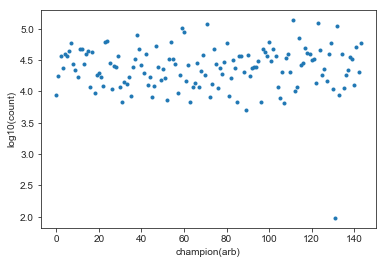

In [5]:
sns.set_style('ticks')
champ_sum = np.concatenate((lol_df['blue_champs0'],lol_df['blue_champs1'],lol_df['blue_champs2'],
            lol_df['blue_champs3'],lol_df['blue_champs4'],lol_df['red_champs0'],
            lol_df['red_champs1'],lol_df['red_champs2'],lol_df['red_champs3'],
            lol_df['red_champs4']),axis=None)

unique, counts = np.unique(champ_sum, return_counts=True)

plt.plot(np.log10(counts),'.')
plt.xlabel('champion(arb)')
plt.ylabel('log10(count)')
plt.show()

## Define preprocess functions

In [8]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [17]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords(filename, examples, target_df,target_name):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    target_array = np.array(target_df[target_name])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i].tostring()
        red_champs = red_hero_array[:][i].tostring()
        target = target_array[i]

        # Create a feature
        if target_name=='blue_win':
            feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _int64_feature(target)}
        else:
            feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _float_feature(target)}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [5]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords_dual(filename, examples, target_df):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    win_array = np.array(target_df['blue_win'])
    gold_diff_array = np.array(target_df['gold_diff'])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i].tostring()
        red_champs = red_hero_array[:][i].tostring()
        blue_win = win_array[i]
        gold_diff = gold_diff_array[i]
        
        # Create a feature
        feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'blue_win': _int64_feature(blue_win),
                   'gold_diff': _float_feature(gold_diff)}

        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [6]:
def preprocess_features(lol_df):
    """Take lol_df and create a dataframe containing only the features for our model
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of champs for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['blue_champs'] = list(np.array(lol_df.loc[:,['blue_champs0',
                                                'blue_champs1','blue_champs2',
                                                'blue_champs3','blue_champs4']]).astype(int))
    processed_df['red_champs'] = list(np.array(lol_df.loc[:,['red_champs0',
                                    'red_champs1','red_champs2',
                                    'red_champs3','red_champs4']]).astype(int))

    return processed_df
    
def preprocess_targets_win(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model. (blue_win here)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    
    return target_df

def preprocess_targets_gold(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['gold_diff'] = (lol_df['blue_gold']-lol_df['red_gold'])/(lol_df['blue_gold']+lol_df['red_gold'])
    target_df['gold_diff'] = (target_df['gold_diff']-target_df['gold_diff'].mean())/target_df['gold_diff'].std()
    return target_df

def preprocess_targets_dual_gold_win(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    target_df['gold_diff'] = (lol_df['blue_gold']-lol_df['red_gold'])/(lol_df['blue_gold']+lol_df['red_gold'])
    target_df['gold_diff'] = (target_df['gold_diff']-target_df['gold_diff'].mean())/target_df['gold_diff'].std()
    return target_df

#this can be easily modified for baron, dragon, or inhib kills
def preprocess_targets_towerkills(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized tower_kill difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (tower_kills)
    """
    tower_kills = np.array([])
    for blue_tow,red_tow in zip(lol_df['blue_tower_kills'],lol_df['red_tower_kills']):
        if blue_tow!=0 or red_tow!=0:
            tower_kills = np.append(tower_kills,(blue_tow-red_tow)/(blue_tow+red_tow))
        else:
            tower_kills = np.append(tower_kills,0)

    target_df = pd.DataFrame()
    target_df['tower_kills'] = tower_kills
    
    return target_df

### Visualize data for each set

In [118]:
plotting_df = lol_df

display.display(plotting_df.iloc[:train_len,:].describe())
display.display(plotting_df.iloc[train_len:train_len+test_len,:].describe())
display.display(plotting_df.iloc[train_len+test_len:,:].describe())

,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,...,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000
mean,0.493517,50680.485081,50903.279766,5.242980,5.248909,0.857834,0.856301,1.335262,1.499419,0.424908,...,127.269331,127.019627,128.507745,128.614763,128.153649,127.973206,128.144673,128.628713,127.358401,126.879039
std,0.499959,15472.969704,15694.932860,3.729527,3.764899,1.113596,1.108683,1.215688,1.268318,0.613160,...,130.112919,129.973630,130.866925,131.147744,130.536470,130.848234,130.301183,131.556544,130.225095,129.781205
min,0.000000,3322.000000,3345.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40870.000000,40883.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,51338.000000,51645.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,85.000000,84.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,84.000000
75%,1.000000,60972.000000,61424.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,150.000000,145.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,150.000000,145.000000
max,1.000000,136791.000000,133619.000000,11.000000,11.000000,13.000000,12.000000,7.000000,9.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,...,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000
mean,0.494691,50668.228299,50890.192402,5.235408,5.250419,0.854612,0.861461,1.331598,1.502638,0.424640,...,126.868751,126.857114,128.325847,128.710843,127.941666,127.822054,129.612706,128.507528,127.569756,127.063621
std,0.499975,15465.506057,15735.268358,3.727461,3.776092,1.114215,1.111371,1.210391,1.268697,0.613413,...,129.646987,130.404031,130.589762,131.507477,130.418035,130.597810,132.273596,131.032627,130.375786,129.715857
min,0.000000,3313.000000,3672.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40889.000000,40854.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,51260.000000,51680.500000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,84.000000,85.000000,85.000000,84.000000,85.000000,85.000000,85.000000,85.000000,85.000000
75%,1.000000,60825.250000,61404.000000,9.000000,9.000000,1.000000,2.000000,2.000000,2.000000,1.000000,...,150.000000,145.000000,154.000000,154.000000,150.000000,154.000000,157.000000,154.000000,150.000000,145.000000
max,1.000000,128579.000000,122758.000000,11.000000,15.000000,10.000000,10.000000,7.000000,7.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,blue_champs0,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4
count,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,...,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000
mean,0.491646,50575.111416,50844.341084,5.219073,5.256702,0.851295,0.858993,1.329447,1.498121,0.419353,...,127.243208,127.406222,128.654229,128.434342,127.477404,126.942900,128.675806,128.672636,125.994657,126.889671
std,0.499936,15518.337369,15739.447085,3.726500,3.764857,1.113047,1.110037,1.212582,1.265722,0.611561,...,129.945030,130.381843,131.023326,131.648542,130.153115,130.039139,130.675896,131.035685,128.626126,129.809846
min,0.000000,3663.000000,3627.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,40708.750000,40806.750000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
50%,0.000000,51202.000000,51657.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,85.000000,85.000000,85.000000,85.000000,84.000000,84.000000,85.000000,85.000000,84.000000,85.000000
75%,1.000000,60909.500000,61431.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,150.000000,145.000000,154.000000,150.000000,150.000000,145.000000,157.000000,154.000000,145.000000,145.000000
max,1.000000,120841.000000,116517.000000,15.000000,12.000000,8.000000,10.000000,7.000000,7.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000


### Export win tfrecord

In [115]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

target_name='blue_win'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])

if target_name=='blue_win':
    train_targets = preprocess_targets_win(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_win(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_win(lol_df.iloc[train_len+test_len:,:])
else:
    train_targets = preprocess_targets_gold(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_gold(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_gold(lol_df.iloc[train_len+test_len:,:])



convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Train data: 0/88336
Train data: 10000/88336
Train data: 20000/88336
Train data: 30000/88336
Train data: 40000/88336
Train data: 50000/88336
Train data: 60000/88336
Train data: 70000/88336
Train data: 80000/88

### Export gold tfrecord

In [13]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

target_name='gold_diff'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])

if target_name=='blue_win':
    train_targets = preprocess_targets_win(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_win(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_win(lol_df.iloc[train_len+test_len:,:])
else:
    train_targets = preprocess_targets_gold(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_gold(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_gold(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Train data: 0/88336
Train data: 10000/88336
Train data: 20000/88336
Train data: 30000/88336
Train data: 40000/88336
Train data: 50000/88336
Train data: 60000/88336
Train data: 70000/88336
Train data: 80000/88

### Export dual gold_win tfrecord

In [9]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

target_name='dual_gold_win'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])


train_targets = preprocess_targets_dual_gold_win(lol_df.iloc[:train_len,:])
test_targets = preprocess_targets_dual_gold_win(lol_df.iloc[train_len:train_len+test_len,:])
validation_targets = preprocess_targets_dual_gold_win(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords_dual(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets)
convert_to_tfrecords_dual(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets)

convert_to_tfrecords_dual(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets)

Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Train data: 0/88336
Train data: 10000/88336
Train data: 20000/88336
Train data: 30000/88336
Train data: 40000/88336
Train data: 50000/88336
Train data: 60000/88336
Train data: 70000/88336
Train data: 80000/88